---
# **SAPIENSAGRO Inteligência Artificial & Treinamentos**
### - Instrutores:
   - Anderson A. Tossani / tossani@sapiensagro.com
   - Gustavo C. Santos  / carvalho@sapiensagro.com


---



## **Curso: Integração Python e Metatrader: Automatização de Ordens e Estratégia**

#### ***Objetivos do Cursos***

  - Aprender a gerar indicadores de momento, indicadores de tendência e padrões de candlesticks;
  - Criar algoritmo que encontre melhores momentos para compra/venda de ativos;
  - Utilizar Python para integração com Metatrader e fazer download das cotações de ativos;
  - Utilizar os algoritmo de estratégias no Metatrader para automatizar compra e venda de um ativo;

## FERRAMENTS UTILIZADAS

  - **Google Colaboratoty**
    - https://colab.research.google.com
  - **PYCHARM Community Edition**
    - https://www.jetbrains.com/pt-br/pycharm/download/#section=windows
  - **Spyder (Anaconda Individual Edition)**
    - https://www.anaconda.com/products/individual
  - **Metatrader 5**
    - https://www.metatrader5.com/pt

  - **Bibliotecas**
    - *Talib*
      - https://mrjbq7.github.io/ta-lib/

    - *Instruções para instalação da ta-lib*
      - Instruções para instalação da ta-lib no Windows estão no site abaixo:
        - - https://blog.quantinsti.com/install-ta-lib-python/

      - **RESUMO em Português**:
        - a) Verfificar a versão do seu S.O
        - b) No site abaixo, escolher o arquivo com extensão *.whl de acordo com a versão correta do seu S.O:
        - https://www.lfd.uci.edu/~gohlke/pythonlibs/#ta-lib

        - c) Copiar o arquivo para a pasta do seu projeto, ou pasta onde os notebooks ficarão armazenados;
        - d) Acessar o prompt de comando do Anaconda:
            - Na barra de pesquisa do Windows, digitar:
            - Aconda Prompt
        - e) Caminhar para a pasta onde o arquivo instalador da ta-lib foi baixado;
        - f) Digitar:
            - pip instal 'nome-do-arquivo.whl'
            - Exemplo: **pip install TA_Lib-0.4.17-cp37-cp37m-win_amd64.whl**
        


---
# **DIVISÃO DESTE CAPÍTULO**

  - PARTE I - Instalação da Talib
  - PARTE II - Importação das Bibliotecas
  - PARTE III - Importando Dados
  - PARTE IV - Criando Estratégias
    - Etapa I) Gerando Candlestick
    - Etapa II) Suavização da Série
    - Etapa III) Gerando Indicadores
    - Etapa IV) Criando Entry/Exit Points (buy/sell)
    - Etapa V) Backtest da Estratégia
  - PARTE V - PLOTANDO GRÁFICOS DAS ESTRATÉGIAS
  ---

# **PARTE I - Instalação da Talib**

#### INSTALAÇÃO DA TALIB

In [112]:
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

(Reading database ... 149432 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.4) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



# **PARTE II IMPORTAÇÃO DE BIBLIOTECAS**


#### Importanbo Bibliotecas 

In [113]:
### Importando as bibliotecas.

##-- Manipulação de datas
import datetime as dt
from datetime import datetime as dtime

##-- Manipulação de DataFrames
import pandas as pd

##-- Manipulação de tempo
import time

##-- Manipulação de arrays e vetores
import numpy as np

##-- Manipulação de gráficos
import plotly.offline as py
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20, 20

##-- Desabilitar avisos (warnings)
import warnings
warnings.filterwarnings('ignore')

##-- Setando valores float para duas casas decimais
pd.set_option('display.float_format', lambda x: '%.2f' % x)

##-- Biblioteca para Indicadores e Padrões em Candlesticks
import talib as ta

# **PARTE III IMPORTANDO DADOS**

#### CARREGANDO CSV

In [114]:
##-- Gerando um DataFrame com as cotações do ativo (MILHO com vencimento em 03/21)

#a) Carregando o dataframe. Excluímos a primeira linha ("skiprows=1") e renomeamos as colunas ("names =")
umj21 = pd.read_csv('umj21_2m.csv', skiprows=1,
                  names=['Date', 'Open', 'High', 'Low', 'Adj Close', 'Change', '%Change', 'Volume', 'Open Int'])

#b) Transformando a feature "Date" em datetime com formato data e hora
umj21['Date'] = pd.to_datetime(umj21.Date, format = '%m/%d/%Y %H:%M')
umj21['Time'] = [dt.datetime.time(d) for d in umj21['Date']]

#c) Eliminando as colunas que não interessam em nossa análise. 
umj21.drop(['Change', '%Change', 'Open Int', 'Time'], axis=1, inplace=True)

#d) Reordenando os registros pela feature "Date".
umj21.sort_values(by='Date', inplace=True)

#e) Indexando os registros pela data (feature "Date").
umj21.index = umj21.Date

#f) Eliminando a feature "Date".
umj21.drop('Date', axis=1, inplace=True)

#g) Renomeando as colunas.
umj21.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

##-- Criando uma cópia do dataset.

stocks = umj21.copy()

# **PARTE IV CRIANDO ESTRETÉGIA**

#### Etapa I) Gerando Candlestick

Referências:
https://plotly.com/python/reference/candlestick/

In [115]:
##-Corte das últimas 60 cotações

df = stocks[-120:].copy()

##--Gerando Gráfico tipo Candlestick com Média Móvel

fig = go.Figure(data=[go.Candlestick(x = df.index,
                                     open = df.Open,
                                     high = df.High,
                                     low = df.Low,
                                     close = df.Close)])
fig.update_traces(showlegend=True, name='WINJ21')
fig.add_trace(go.Scatter(x = df.index, y=df.Close.ewm(span=5).mean(),
                         mode="lines", line=dict(color="green"), name='EMA5'))
fig.add_trace(go.Scatter(x = df.index, y=df.Close.ewm(span=20).mean(),
                         mode="lines", line=dict(color="red"), name='EMA17'))
fig.show()

#### Etapa II) Suavização da Série

In [116]:
##-- Vamos 'suavizar' a série gerando utilizando a Talib

#a) Suavização da série

suavização = 5

#b) Gerando as features OHLC suavizadas

stocks['EMAC'] = ta.EMA(stocks['Close'],  timeperiod=suavização)   # Suavização da série de fechamento
stocks['EMAO'] = ta.EMA(stocks['Open'],   timeperiod=suavização)   # Suavização da série de abertura
stocks['EMAH'] = ta.EMA(stocks['High'],   timeperiod=suavização)   # Suavização da série de Altas
stocks['EMAL'] = ta.EMA(stocks['Low'],    timeperiod=suavização)   # Suavização da série de Baixas
stocks['EMAV'] = ta.EMA(stocks['Volume'], timeperiod=suavização)   # Suavização da série de Volume

#### Etapa III) Gerando Indicadores

In [117]:
##-- Gerando os Osciladores e Indicadores de Tendência

#1) RSI - Relative Strength Index
stocks['RSI'] = ta.RSI(stocks['EMAC'], timeperiod=14)

#2) MACD - Moving Average Convergence/Divergence
stocks['macd'], stocks['macdsignal'], stocks['macdhist'] = ta.MACD(stocks['EMAC'], fastperiod=12, slowperiod=26
                                                       , signalperiod=9)
#3) Parabolic SAR
stocks['SAR'] = ta.SAR(stocks['EMAH'], stocks['EMAL'], 0.02, 0.3)
stocks['SAREXT'] = ta.SAREXT(stocks['EMAH'], stocks['EMAL'], 0.02, 0.3)

#4) CCI - Commodity Channel Index
stocks['CCI'] = ta.CCI(stocks['EMAH'], stocks['EMAL'], stocks['EMAC'],  timeperiod=14)

#5) SMA - Single Moving Average
sht = 2
lng = 25
stocks['SHT'] = stocks['Close'].rolling(window=sht).mean()
stocks['LNG'] = stocks['Close'].rolling(window=lng).mean()

#6) Bollinger Bands
stocks['UPP'], stocks['MIDD'], stocks['LOW'] = ta.BBANDS(stocks['EMAC'], timeperiod=6, nbdevup=4, nbdevdn=4, matype=0)

#7) Top & Bottom
stocks['Close20d'] = stocks.Close.shift(20)
stocks['Close30d'] = stocks.Close.shift(30)
stocks['Close40d'] = stocks.Close.shift(40)
stocks['Close50d'] = stocks.Close.shift(50)
stocks['Close60d'] = stocks.Close.shift(60)

#8) TOP & BOTTOM

Lenght = 60

stocks['MIN_'+str(Lenght)] = list(np.zeros(len(stocks)))
stocks['MAX_'+str(Lenght)] = list(np.zeros(len(stocks)))
for i in range(len(stocks)-Lenght):
    stocks['MIN_'+str(Lenght)][i+Lenght] = stocks.Close[i:i+Lenght].min()
    stocks['MAX_'+str(Lenght)][i+Lenght] = stocks.Close[i:i+Lenght].max()
stocks.dropna(axis=0, inplace=True)



##-- Padrões de Candlesticks. Caso queira operar utilizando a informação dos padrões, segue aqui como calcular.

stocks['DOJI'] = ta.CDLDOJI(stocks['Open'], stocks['High'], stocks['Low'], stocks['Close'])
stocks['3CROWS'] = ta.CDLIDENTICAL3CROWS(stocks['Open'], stocks['High'], stocks['Low'], stocks['Close'])
stocks['MAROBUZU'] = ta.CDLMARUBOZU(stocks['Open'], stocks['High'], stocks['Low'], stocks['Close'])
stocks['TRISTAR'] = ta.CDLTRISTAR(stocks['Open'], stocks['High'], stocks['Low'], stocks['Close'])
stocks['MORNINGDOJISTAR'] = ta.CDLMORNINGDOJISTAR(stocks['Open'], stocks['High'], stocks['Low'], stocks['Close'],\
                                                  penetration = 0.3)
stocks['ABANDONEDBABY'] = ta.CDLABANDONEDBABY(stocks['Open'], stocks['High'], stocks['Low'], stocks['Close'],\
                                              penetration = 0.3)
stocks['XSIDEGAP3METHODS'] = ta.CDLXSIDEGAP3METHODS(stocks['Open'], stocks['High'], stocks['Low'], stocks['Close'])
stocks['HAMMER'] = ta.CDLHAMMER(stocks['Open'], stocks['High'], stocks['Low'], stocks['Close'])
stocks['DRAGONFLYDOJI'] = ta.CDLDRAGONFLYDOJI(stocks['Open'], stocks['High'], stocks['Low'], stocks['Close'])
stocks['MORNINGSTAR'] = ta.CDLMORNINGSTAR(stocks['Open'], stocks['High'], stocks['Low'], stocks['Close'],\
                                          penetration = 0.3)
stocks['EVENINGSTAR'] = ta.CDLEVENINGSTAR(stocks['Open'], stocks['High'], stocks['Low'], stocks['Close'],\
                                          penetration = 0.3)
stocks['HANGINGMAN'] = ta.CDLHANGINGMAN(stocks['Open'], stocks['High'], stocks['Low'], stocks['Close'])
stocks['ENGULFING'] = ta.CDLENGULFING(stocks['Open'], stocks['High'], stocks['Low'], stocks['Close'])

#### Etapa IV) Criando Entry/Exit Points (buy/sell)
   - Indicadores
       - a) SMA CROSSING
       - b) MACD
       - c) RSI
       - d) CCI
       - e) SAR
       - f) Bollinger Bands
       - g) Reversão de Tendência
       - h) Seguidor de Tendência

###a) SMA CROSSING

  - Consiste no cruzamento de duas médias móveis (curvas suavizadas).
    - Quando a média curta cruza a longa para cima: momento de compra;
    - Quando a média curta cruza a longa para baixo: momento de venda.

In [118]:
'''
#a)-- Utilizando Médias Móveis

##--Estratégia: quando a média curta for maior que a longa, compra. Quando for menor, vende.
stocks['Status'] = stocks['SHT'] > stocks['LNG']

##-Racional
stocks['Statusd-1'] = stocks['Status'].shift(1)
stocks['has_action'] = stocks['Status'] != stocks['Statusd-1']
stocks.dropna(axis=0, inplace=True)
stocks.loc[(stocks['Status']==True)&(stocks['has_action']==True), 'action'] = 'buy'
stocks.loc[(stocks['Status']==False)&(stocks['has_action']==True), 'action'] = 'sell'
stocks['action'].fillna('wait', inplace=True)
stock_action = stocks[stocks['action'] != 'wait']
'''

"\n#a)-- Utilizando Médias Móveis\n\n##--Estratégia: quando a média curta for maior que a longa, compra. Quando for menor, vende.\nstocks['Status'] = stocks['SHT'] > stocks['LNG']\n\n##-Racional\nstocks['Statusd-1'] = stocks['Status'].shift(1)\nstocks['has_action'] = stocks['Status'] != stocks['Statusd-1']\nstocks.dropna(axis=0, inplace=True)\nstocks.loc[(stocks['Status']==True)&(stocks['has_action']==True), 'action'] = 'buy'\nstocks.loc[(stocks['Status']==False)&(stocks['has_action']==True), 'action'] = 'sell'\nstocks['action'].fillna('wait', inplace=True)\nstock_action = stocks[stocks['action'] != 'wait']\n"

###b) MACD *(Moving Average Convergence Divergence)*

  - Consiste no cruzamento de duas médias móveis exponenciais (curvas suavizadas).
    - Quando a linha MACD cruza a linha de sinal para cima: momento de compra;
    - Quando a linha MACD cruza a linha de sinal para baixo: momento de venda;

In [119]:
'''
#b)-- Utilizando MACD

##--Estratégia: quando a média curta for maior que a longa, compra. Quando for menor, vende.
stocks['Status'] = stocks['macd'] > stocks['macdsignal']

##--Racional
stocks['Statusd-1'] = stocks['Status'].shift(1)
stocks['has_action'] = stocks['Status'] != stocks['Statusd-1']
stocks.dropna(axis=0, inplace=True)
stocks.loc[(stocks['Status']==True)&(stocks['has_action']==True), 'action'] = 'buy'
stocks.loc[(stocks['Status']==False)&(stocks['has_action']==True), 'action'] = 'sell'
stocks['action'].fillna('wait', inplace=True)
stock_action = stocks[stocks['action'] != 'wait']
'''

"\n#b)-- Utilizando MACD\n\n##--Estratégia: quando a média curta for maior que a longa, compra. Quando for menor, vende.\nstocks['Status'] = stocks['macd'] > stocks['macdsignal']\n\n##--Racional\nstocks['Statusd-1'] = stocks['Status'].shift(1)\nstocks['has_action'] = stocks['Status'] != stocks['Statusd-1']\nstocks.dropna(axis=0, inplace=True)\nstocks.loc[(stocks['Status']==True)&(stocks['has_action']==True), 'action'] = 'buy'\nstocks.loc[(stocks['Status']==False)&(stocks['has_action']==True), 'action'] = 'sell'\nstocks['action'].fillna('wait', inplace=True)\nstock_action = stocks[stocks['action'] != 'wait']\n"

###c) RSI *(Relative Strength Index)*

  - Quando o valor de RSI está acima de 70 (valor definido de acordo com a estratégia do usuário): indica região de sobrecompra, temos tendência de queda;
  - Quando o valor de RSI está abaixo de 30 (valor definido de acordo com a estratégia do usuário): indica região de sobrevenda, temos tendência de alta;

In [120]:
'''
#c)-- Utilizando RSI

##--Estratégia: quando RSI > 70, venda. Quando RSI < 30, compra.
stocks['RSISTATUS'] = [0]*len(stocks)   ## criando uma lista com a mesma quantidade de registro do dataframe stocks
stocks['Status'] = [0]*len(stocks)      ## criando uma lista com a mesma quantidade de registro do dataframe stocks
for i in range(len(stocks)):            ## criando um laço para preencher a feature 'Status'
    if stocks['RSI'][i] > 70:
        stocks['Status'][i] = True
    elif stocks['RSI'][i] < 30:
        stocks['Status'][i] = False
    else:
        stocks['Status'][i] = 0

##--Racional
stocks['Statusd-1'] = stocks['Status'].shift(1)                    
stocks['Statusd-1'] = stocks['Status'].shift(1)
stocks['has_action'] = stocks['Status'] != stocks['Statusd-1']
stocks.dropna(axis=0, inplace=True)
stocks.loc[(stocks['Status']==True)&(stocks['has_action']==True), 'action'] = 'buy'
stocks.loc[(stocks['Status']==False)&(stocks['has_action']==True), 'action'] = 'sell'
stocks['action'].fillna('wait', inplace=True)
stock_action = stocks[stocks['action'] != 'wait']
'''

"\n#c)-- Utilizando RSI\n\n##--Estratégia: quando RSI > 70, venda. Quando RSI < 30, compra.\nstocks['RSISTATUS'] = [0]*len(stocks)   ## criando uma lista com a mesma quantidade de registro do dataframe stocks\nstocks['Status'] = [0]*len(stocks)      ## criando uma lista com a mesma quantidade de registro do dataframe stocks\nfor i in range(len(stocks)):            ## criando um laço para preencher a feature 'Status'\n    if stocks['RSI'][i] > 70:\n        stocks['Status'][i] = True\n    elif stocks['RSI'][i] < 30:\n        stocks['Status'][i] = False\n    else:\n        stocks['Status'][i] = 0\n\n##--Racional\nstocks['Statusd-1'] = stocks['Status'].shift(1)                    \nstocks['Statusd-1'] = stocks['Status'].shift(1)\nstocks['has_action'] = stocks['Status'] != stocks['Statusd-1']\nstocks.dropna(axis=0, inplace=True)\nstocks.loc[(stocks['Status']==True)&(stocks['has_action']==True), 'action'] = 'buy'\nstocks.loc[(stocks['Status']==False)&(stocks['has_action']==True), 'action'] =

##d) CCI *(Commodity Channel Index)*

  - Quando o valor de CCI está acima de 100: indica região de sobrecompra, temos tendência de queda;
  - Quando o valor de CCI está abaixo de -100: indica região de sobrevenda, temos tendência de alta;

In [121]:
'''
#d)-- Utilizando CCI

##--Estratégia: quando CCI > 100, venda. Quando CCI < -100, compra.

statuscci = list(np.zeros(len(stocks)))
for i in range(len(stocks)):
    if stocks.CCI[i] < -100 :
        statuscci[i] = True
    elif stocks.CCI[i] > 100:
        statuscci[i] = False
    else:
        status[i] = 'nd'
        

##--Racional
stocks['status'] = statuscci
stocks = stocks[stocks.status != 'nd']
stocks['statusd'] = stocks.status.shift(1)
stocks['has_action'] = stocks.status != stocks.statusd
stocks = stocks[stocks.has_action == True]
stocks.dropna(axis=0, inplace=True)
stocks.loc[(stocks['has_action'] == True) & (stocks['status'] == 'Falso'), 'action'] = 'sell'
stocks.loc[(stocks['has_action'] == True) & (stocks['status'] == 'Verdadeiro'), 'action'] = 'buy'
stocks['action'].fillna('wait', inplace=True)
stock_action = stocks[stocks['action'] != 'wait']
'''

"\n#d)-- Utilizando CCI\n\n##--Estratégia: quando CCI > 100, venda. Quando CCI < -100, compra.\n\nstatuscci = list(np.zeros(len(stocks)))\nfor i in range(len(stocks)):\n    if stocks.CCI[i] < -100 :\n        statuscci[i] = True\n    elif stocks.CCI[i] > 100:\n        statuscci[i] = False\n    else:\n        status[i] = 'nd'\n        \n\n##--Racional\nstocks['status'] = statuscci\nstocks = stocks[stocks.status != 'nd']\nstocks['statusd'] = stocks.status.shift(1)\nstocks['has_action'] = stocks.status != stocks.statusd\nstocks = stocks[stocks.has_action == True]\nstocks.dropna(axis=0, inplace=True)\nstocks.loc[(stocks['has_action'] == True) & (stocks['status'] == 'Falso'), 'action'] = 'sell'\nstocks.loc[(stocks['has_action'] == True) & (stocks['status'] == 'Verdadeiro'), 'action'] = 'buy'\nstocks['action'].fillna('wait', inplace=True)\nstock_action = stocks[stocks['action'] != 'wait']\n"

###e) PARABOLIC SAR *(Stop And Reverse)*

  - Quando o valor de SAR está acima do preço de fechamento (ou máximo, ou abertura, etc..): temos tendência de queda;
  - Quando o valor de SAR está abaixo do preço de fechamento (ou máximo, ou abertura, etc..): temos tendência de alta;

In [122]:
'''
#e)-- Utilizando SAR

##--Estratégia: quando SAR > Preço do ativo, venda. Quando SAR < Preço do ativo, compra.
stocks['Status'] = stocks['SAR'] <= stocks['Close']

##--Racional
stocks['Statusd-1'] = stocks['Status'].shift(1)
stocks['has_action'] = stocks['Status'] != stocks['Statusd-1']
stocks.dropna(axis=0, inplace=True)
stocks.loc[(stocks['Status']==True)&(stocks['has_action']==True), 'action'] = 'buy'
stocks.loc[(stocks['Status']==False)&(stocks['has_action']==True), 'action'] = 'sell'
stocks['action'].fillna('wait', inplace=True)
stock_action = stocks[stocks['action'] != 'wait']
'''

###f) BOLLINGER BANDS

  - Quando o preço de fechamento (ou máximo, ou abertura, etc..) rompe a linha da banda superior: temos tendência de queda para os próximos períodos;
  - Quando o preço de fechamento (ou máximo, ou abertura, etc..) rompe a linha da banda inferior: temos tendência de alta para os próximos períodos;

In [123]:
'''
#f)-- Utilizando Bollinger Bands

##--Estratégia: quando Preço Ativo > Banda superior, venda. Quando Preço Ativo < Banda inferior, compra.

bollinger = lambda x, y, z: True if x > y else (False if x<z else np.nan)
status = list(np.zeros(len(stocks)))
for i in range(len(stocks)):
    if stocks.Close[i] > stocks.UPP[i]:
        status[i] = 'Falso'
    elif stocks.Close[i] < stocks.LOW[i]:
        status[i] = 'Verdadeiro'
    else:
        status[i] = 'nd'
        

##--Racional
stocks['status'] = status
stocks = stocks[stocks.status != 'nd']
stocks['statusd'] = stocks.status.shift(1)
stocks['has_action'] = stocks.status != stocks.statusd
stocks = stocks[stocks.has_action == True]
stocks.dropna(axis=0, inplace=True)
stocks.loc[(stocks['has_action'] == True) & (stocks['status'] == 'Falso'), 'action'] = 'sell'
stocks.loc[(stocks['has_action'] == True) & (stocks['status'] == 'Verdadeiro'), 'action'] = 'buy'
stocks['action'].fillna('wait', inplace=True)
stock_action = stocks[stocks['action'] != 'wait']
'''

"\n#f)-- Utilizando Bollinger Bands\n\n##--Estratégia: quando Preço Ativo > Banda superior, venda. Quando Preço Ativo < Banda inferior, compra.\n\nbollinger = lambda x, y, z: True if x > y else (False if x<z else np.nan)\nstatus = list(np.zeros(len(stocks)))\nfor i in range(len(stocks)):\n    if stocks.Close[i] > stocks.UPP[i]:\n        status[i] = 'Falso'\n    elif stocks.Close[i] < stocks.LOW[i]:\n        status[i] = 'Verdadeiro'\n    else:\n        status[i] = 'nd'\n        \n\n##--Racional\nstocks['status'] = status\nstocks = stocks[stocks.status != 'nd']\nstocks['statusd'] = stocks.status.shift(1)\nstocks['has_action'] = stocks.status != stocks.statusd\nstocks = stocks[stocks.has_action == True]\nstocks.dropna(axis=0, inplace=True)\nstocks.loc[(stocks['has_action'] == True) & (stocks['status'] == 'Falso'), 'action'] = 'sell'\nstocks.loc[(stocks['has_action'] == True) & (stocks['status'] == 'Verdadeiro'), 'action'] = 'buy'\nstocks['action'].fillna('wait', inplace=True)\nstock_actio

##g) REVERSÃO DE TENDÊNCIA

  - Não se trata de um indicador técnico já validado. Trata-se de um indicador criado para este treinamento.

  - O indicador acompanha as reversões de preços e indica compra/venda de acordo com estas reversões;

In [124]:
'''
#g)--Estratégia Reversão Tendência

stocks['Direction'] = stocks.Close - stocks.Close.shift(1)
stocks['Reversao'] = np.where(stocks.Direction > 0, 1, -1)

status = lambda x: True if x == 1 else False
stocks['status'] = stocks.Reversao.apply(status)
stocks['statusd-1'] = stocks.status.shift(1)
stocks['has_action'] = stocks['status'] != stocks['statusd-1']
stocks.dropna(axis=0, inplace=True)
stocks.loc[(stocks.has_action == True) & (stocks.status == True), 'action'] = 'buy'
stocks.loc[(stocks.has_action == True) & (stocks.status == False), 'action'] = 'sell'
stocks.fillna('wait')
stocks = stoks[stocks['action'] != 'wait']
stocks.dropna(axis=0, inplace=True)
stock_action = stocks.copy()
'''

"\n#g)--Estratégia Reversão Tendência\n\nstocks['Direction'] = stocks.Close - stocks.Close.shift(1)\nstocks['Reversao'] = np.where(stocks.Direction > 0, 1, -1)\n\nstatus = lambda x: True if x == 1 else False\nstocks['status'] = stocks.Reversao.apply(status)\nstocks['statusd-1'] = stocks.status.shift(1)\nstocks['has_action'] = stocks['status'] != stocks['statusd-1']\nstocks.dropna(axis=0, inplace=True)\nstocks.loc[(stocks.has_action == True) & (stocks.status == True), 'action'] = 'buy'\nstocks.loc[(stocks.has_action == True) & (stocks.status == False), 'action'] = 'sell'\nstocks.fillna('wait')\nstocks = stoks[stocks['action'] != 'wait']\nstocks.dropna(axis=0, inplace=True)\nstock_action = stocks.copy()\n"

###h) SEGUIDOR DE TENDÊNCIA

  - Não se trata de um indicador técnico já validado. Trata-se de um indicador criado para este treinamento. O indicador acompanha as sequências de alta e queda e indica um ponto de compra quando uma sequencia é interrompida.
  - Se uma sequência de 6 quedas (-seed + 4) é interrompida, temos um ponto de compra;
  - Se uma sequência de 6 altas (seed - 4) é interrompida, temos um ponto de venda;

In [125]:
'''

#h)--Seguidor de Tendência
stocks['Dif'] = stocks.Close - stocks.Close.shift(1)
stocks['Direction'] = np.where(stocks.Dif >=0, 1, -1)
stocks['status'] = list(np.zeros(len(stocks)))

seed = 10

for i in range(seed, len(stocks), seed):
    if sum(stocks.Direction[i-seed:i]) <= -seed+4:
        stocks['status'][i] = -1
    if sum(stocks.Direction[i-seed:i]) >= seed-4:
        stocks['status'][i] = 1
##--Racional
stocks = stocks[stocks['status'] != 0]
stocks['statusd-1'] = stocks['status'].shift(1)
stocks['has_action'] = (stocks['status'] != stocks['statusd-1'])
stocks.loc[(stocks['has_action'] == True) & (stocks['status'] == 1), 'action'] = 'sell'
stocks.loc[(stocks['has_action'] == True) & (stocks['status'] == -1), 'action'] = 'buy'
stocks.action.fillna('wait', inplace=True)
stock_action = stocks[stocks.action != 'wait']
'''

"\n\n#h)--Seguidor de Tendência\nstocks['Dif'] = stocks.Close - stocks.Close.shift(1)\nstocks['Direction'] = np.where(stocks.Dif >=0, 1, -1)\nstocks['status'] = list(np.zeros(len(stocks)))\n\nseed = 10\n\nfor i in range(seed, len(stocks), seed):\n    if sum(stocks.Direction[i-seed:i]) <= -seed+4:\n        stocks['status'][i] = -1\n    if sum(stocks.Direction[i-seed:i]) >= seed-4:\n        stocks['status'][i] = 1\n##--Racional\nstocks = stocks[stocks['status'] != 0]\nstocks['statusd-1'] = stocks['status'].shift(1)\nstocks['has_action'] = (stocks['status'] != stocks['statusd-1'])\nstocks.loc[(stocks['has_action'] == True) & (stocks['status'] == 1), 'action'] = 'sell'\nstocks.loc[(stocks['has_action'] == True) & (stocks['status'] == -1), 'action'] = 'buy'\nstocks.action.fillna('wait', inplace=True)\nstock_action = stocks[stocks.action != 'wait']\n"

#### Etapa V) Backtest da Estratégia

  - a) Criando as features
  - b) Criando as funções de backtest
  - c) Executando as funções
  - d) Calculando o Retorno Final da Estratégia

######a) CRIANDO AS FEATURES

In [126]:
##--Definindo os parâmetros Iniciais

#a)-- Saldo inicial da conta
initial_amount = 150000

#b)-- Corretagem
fixed_fee = 10

#c)-- Emolumentos
variable_fee = 0.00031302

#d)-- Gerando as variáveis para backtest

cashstart = np.zeros(len(stock_action))     #Caixa Inicial
cashend = np.zeros(len(stock_action))       #Caixa Final
stockstart = np.zeros(len(stock_action))    #Estoque Inicial do Ativo
stockend = np.zeros(len(stock_action))      #Estoque Final do Ativo
volumebought = np.zeros(len(stock_action))  #Volume Comprado
volumesold = np.zeros(len(stock_action))    #Volume Vendido
stockprice = np.zeros(len(stock_action))    #Cotação do Ativo

#####b) CRIANDO AS FUNÇÕES DE BACKTEST

In [127]:
##-- Rodando Estratégia de Compra/Vemda

def evaluate_stock(stock_action, initial_amount, fixed_fee, return_type ='finalReturn'):
    
    global returndf
    
    for i in range(len(stock_action)):
        
        # a lista stockprice vai iterar as linhas da stockaction
        stockprice[i] = stock_action['Close'][i]
        
        if i == 0:
            # no primeiro dia o cashstart vai ser o capital inicial
            cashstart[i] = initial_amount
        else:
            # cashtart de d é o cashend de d-1
            cashstart[i] = cashend[i-1]
            # o stockstart de d é o stockend de d-1
            stockstart[i] = stockend[i-1]
        
        if (stock_action['action'][i]) == 'buy':
            # quando a decisão for pela compra, vamos fazer uma divisão da parte inteira
            stockend[i] = (cashstart[i]-fixed_fee) // stockprice[i]
            # vamos calcular o volume comprado
            volumebought[i] = stockend[i] * stockprice[i]
            # vamos calcular o caixa final
            cashend[i] = cashstart[i] - volumebought[i]

        elif stock_action['action'][i] == 'sell':
            # quando a decisão for pela venda, vamos calcular o volume vendido
            volumesold[i] = stockstart[i] * stockprice[i]
            # vamos calcular o caixa final
            cashend[i] = (cashstart[i] + volumesold[i])-fixed_fee
       
        else:
            # mensagem de erro
            print('ERRO: temos um valor de acton diferente de BUY e SELL')
       

    ##-- Vamos criar um dataframe com os valores de cada variável do backtest        
    returndf = pd.DataFrame([cashstart, stockstart, stockprice, volumebought, volumesold, stockend, cashend])
    ##-- Vamos pivotar o dataframe
    returndf = returndf.T
    ## Vamos criar o label das features
    returndf.columns = 'cashstart stockstart stockprice volumebought volumesold stockend cashend'.split(' ')
    ##-- Retornando o DataFrame do backtest ou o dataframe do retorno
    if return_type == 'df':
        return returndf[returndf['cashstart'] > 0]
    elif return_type == 'finalReturn':
        profit = (cashend[-1] / initial_amount)-1
        print('Retorno apurado pela operação foi de {} ' .format(profit.round(2)),'%')
        return profit
    else:
        return print('Tipo de retorno inválido')

#####C) EXECUTANDO AS FUNÇÕES

In [128]:
##-- Inicializando a função de backtest
final_return = evaluate_stock(stock_action, initial_amount, fixed_fee)

##-- Criando um dataframe com o retorno da estratégia
result = pd.DataFrame([[final_return]], columns = ['final_return'], index = [stocks])

##--Calculando o retorno mensal e anual da estratégia
mounth_diff = (stocks.index[-1] - stocks.index[0]) / np.timedelta64(1, 'M')
year_diff = mounth_diff / 12
result['AnualRatePercent'] = (result['final_return'] ** (1 / year_diff) - 1) * 100
result['MounthRatePercent'] = (result['final_return'] ** (1 / mounth_diff) - 1) * 100

##-- Inicializando o backtest
evaluate_stock(stock_action, initial_amount, fixed_fee, 'df')

Retorno apurado pela operação foi de -0.04  %


,cashstart,stockstart,stockprice,volumebought,volumesold,stockend,cashend
0,150000.00,0.00,117520.00,0.00,0.00,0.00,149990.00
1,149990.00,0.00,116725.00,116725.00,0.00,1.00,33265.00
2,33265.00,1.00,118500.00,0.00,118500.00,0.00,151755.00
3,151755.00,0.00,118800.00,118800.00,0.00,1.00,32955.00
4,32955.00,1.00,118650.00,0.00,118650.00,0.00,151595.00
...,...,...,...,...,...,...,...
370,34645.00,1.00,110490.00,0.00,110490.00,0.00,145125.00
371,145125.00,0.00,110660.00,110660.00,0.00,1.00,34465.00
372,34465.00,1.00,110240.00,0.00,110240.00,0.00,144695.00
373,144695.00,0.00,110375.00,110375.00,0.00,1.00,34320.00


#####d) CALCULANDO RETORNO

In [129]:
##--Vamos calcular o retorno da estratégia com o backtest

if returndf.iloc[-1, -3] > 0:
    print(f'Retorno total {(((returndf.iloc[-1, -1] / returndf.iloc[0, 0])-1) * 100):.4f}%')
else:
    print(f'Retorno total {(((returndf.iloc[-2, -1] / returndf.iloc[0, 0])-1) * 100):.4f}%')

Retorno total -3.6800%


# **PARTE V - PLOTANDO GRÁFICOS DAS ESTRATÉGIAS**

  - 1) SMA CROSSING
  - 2) PARABOLIC SAR
  - 3) REVERSÃO DE TENDÊNCIA
  - 4) BANDAS DE BOLLINGER
  - 5) SEGUIDOR DE TENDÊNCIA

##1) SMA CROSSING

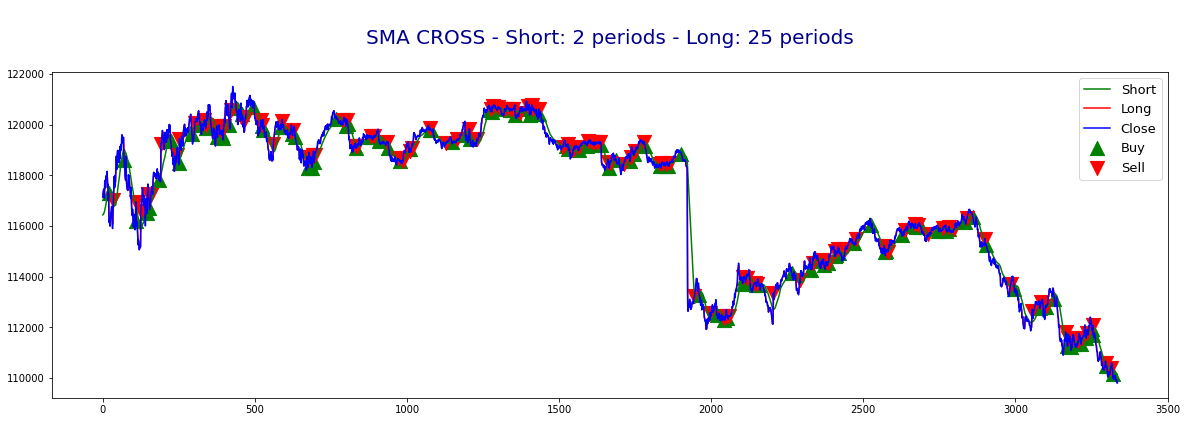

In [136]:
#------------------------------------------------------SMA CROSSING------------------------------------------------------#
##--Criando a Estratégia de buy and sell
sell = np.where((stocks.SHT > stocks.LNG) & (stocks.SHT.shift(1) < stocks.LNG.shift(1)), stocks.Close, np.nan)
buy = np.where((stocks.SHT < stocks.LNG) & (stocks.SHT.shift(1) > stocks.LNG.shift(1)), stocks.Close, np.nan)

##--Plotando o cruzamento de acordo com a estratégia
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(range(len(stocks)), buy, marker='^', color='green', s=200, label='Buy')
ax.scatter(range(len(stocks)), sell, marker='v', color='red', s=200, label='Sell')
ax.plot(range(len(stocks)), stocks.LNG, color='green', label='Short')
ax.plot(range(len(stocks)), stocks.SHT, color='red', label='Long')
ax.plot(range(len(stocks)), stocks.Close, color='blue', label='Close')
ax.legend(fontsize=13)
ax.set_title(f'\nSMA CROSS - Short: {sht} periods - Long: {lng} periods\n', fontsize=20, color='darkblue');

##2) PARABOLIC SAR

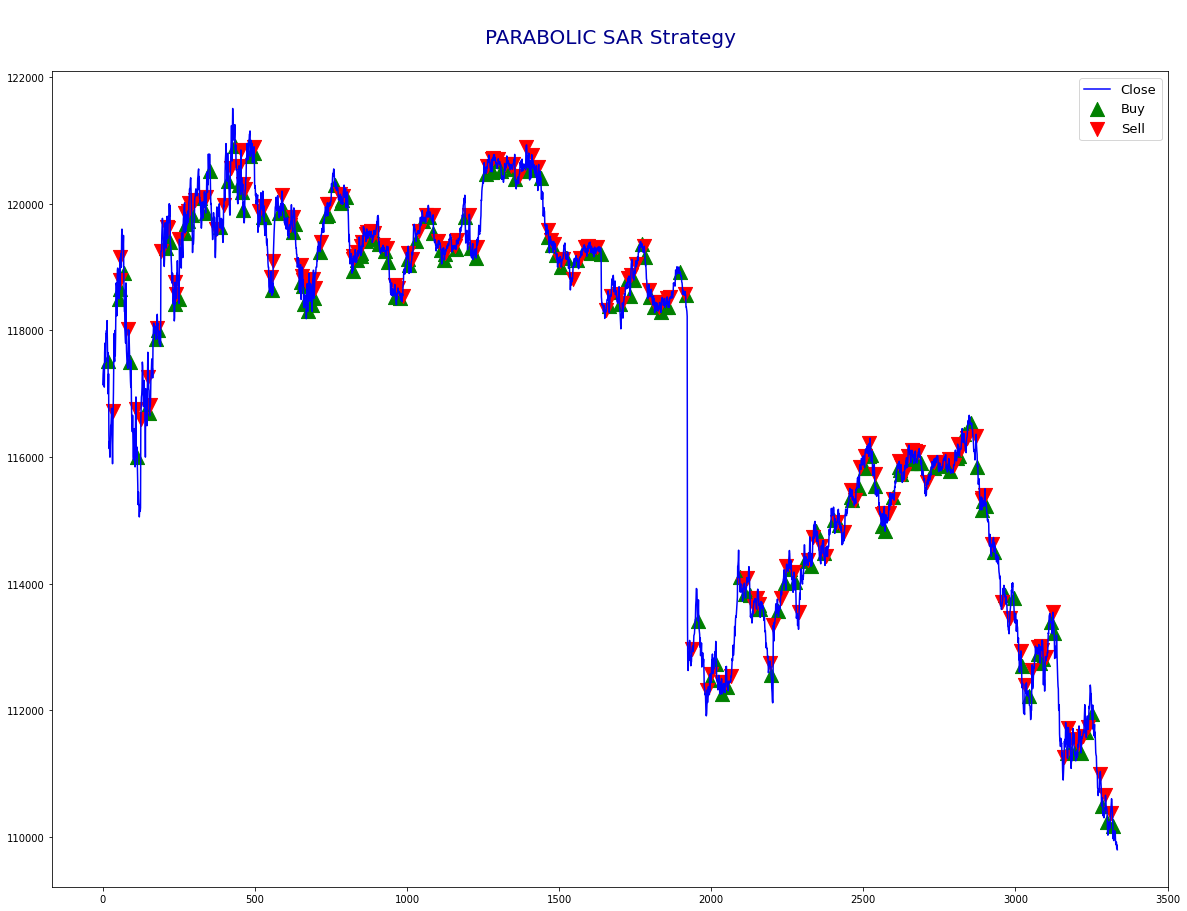

In [139]:
#----------------------------------------------------PARABOLIC SAREXT-------------------------------------------------------#
##--Criando a Estratégia de buy and sell

buysar = np.where((stocks.Close < stocks.SAR) & (stocks.Close.shift(1) > stocks.SAR.shift(1)), stocks.Close, np.nan)
sellsar = np.where((stocks.Close > stocks.SAR) & (stocks.Close.shift(1) < stocks.SAR.shift(1)), stocks.Close, np.nan)

##--Plotando os pontos de entrada e saída
fig, ax = plt.subplots(figsize=(20,15))
ax.scatter(range(len(stocks)), buysar, s=200, marker='^', color='green', label='Buy')
ax.scatter(range(len(stocks)), sellsar, s=200, marker='v', color='red', label='Sell')
ax.plot(range(len(stocks)), stocks.Close, color='blue', label='Close')
ax.legend(fontsize=13)
ax.set_title(f'\nPARABOLIC SAR Strategy\n', fontsize=20, color='darkblue');


##3) REVERSÃO DE TENDÊNCIA

In [ ]:
#----------------------------------------------------REVERSÃO TENDÊNCIA---------------------------------------------------#
##--Criando a Estratégia de buy and sell
#stocks = stocks[-49:]
sellrev = np.where((stocks.action == 'buy'), stocks.Close, np.nan)
buyrev = np.where((stocks.action == 'sell'), stocks.Close, np.nan)

##--Plotando os pontos de entrada e saída
fig, ax = plt.subplots(figsize=(20,15))
ax.scatter(range(len(stocks)), buyrev, s=200, marker='^', color='green', label='Buy')
ax.scatter(range(len(stocks)), sellrev, s=200, marker='v', color='red', label='Sell')
ax.plot(range(len(stocks)), stocks.Close, color='blue', label='Close')
ax.legend(fontsize=13)
ax.set_title(f'\nREVERSÃO DE TENDÊNCIA Strategy\n', fontsize=20, color='darkblue');


##4) BANDAS DE BOLLINGER

In [ ]:
#----------------------------------------------------BANDAS DE BOLLINGER---------------------------------------------------#
##--Criando a Estratégia de buy and sell
#stocks = stocks[-150:-70]
bollup = np.where((stocks.action == 'buy'), stocks.Close, np.nan)
bolldown = np.where((stocks.action == 'sell'), stocks.Close, np.nan)

##--Plotando os pontos de entrada e saída
fig, ax = plt.subplots(figsize=(20,15))
ax.scatter(range(len(stocks)), bollup, s=200, marker='^', color='green', label='Buy')
ax.scatter(range(len(stocks)), bolldown, s=200, marker='v', color='red', label='Sell')
ax.plot(range(len(stocks)), stocks.Close, color='blue', label='Close')
ax.plot(range(len(stocks)), stocks.UPP, color='red', label='Booling. UPP')
ax.plot(range(len(stocks)), stocks.LOW, color='black', label='Booling. LOW')
ax.legend(fontsize=13)
ax.set_title(f'\nBANDAS DE BOLLINGER\n', fontsize=20, color='darkblue');

##5) SEGUIDOR DE TENDÊNCIA

In [ ]:
#----------------------------------------------------SEGUIDOR DE TENDÊNCIA----------------------------------------------#
##--Criando a Estratégia de buy and sell
#stocks = stocks[-150:-70]
tendup = np.where((stocks.action == 'buy'), stocks.Close, np.nan)
tenddown = np.where((stocks.action == 'sell'), stocks.Close, np.nan)

##--Plotando os pontos de entrada e saída
fig, ax = plt.subplots(figsize=(20,15))
ax.scatter(range(len(stocks)), tendup, s=200, marker='^', color='green', label='Buy')
ax.scatter(range(len(stocks)), tenddown, s=200, marker='v', color='red', label='Sell')
ax.plot(range(len(stocks)), stocks.Close, color='blue', label='Close')
ax.legend(fontsize=13)
ax.set_title(f'\nSEGUIDOR DE TENDENCIA\n', fontsize=20, color='darkblue');